In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mdtraj as md
import openpathsampling as paths
import numpy as np
from octomore import Unimore, Src, Abl
import glob

In [2]:
# if Unimore is a superclass that has some CV associated, then with no CV it is less, rather than more
less = Unimore(kinase=Src)

In [12]:
# just a convenience function
# we use mdtraj to load the trajectory, then we convert it to an OPS trajectory
def ops_load_trajectory(filename):
    return paths.engines.openmm.tools.trajectory_from_mdtraj(md.load(filename))

In [13]:
# default directory: assumes you have hal:/cbio mounted at localhost:/cbio
dir11400="/cbio/jclab/projects/fah/fah-data/munged2/no-solvent/11400/"
# in practice, I found it better to scp the files to a local directory (especially for development/testing)
dir11400="local_11400/"
run_num=24
files = glob.glob(dir11400+"run"+str(run_num)+"*.h5")
print len(files)

20


In [14]:
%%time
# make a dictionary mapping the filename to a list of DFG angles at each snapshot
dfg_angle_trajectories = {
    f : less.dfg(ops_load_trajectory(f)) 
    for f in files
}

CPU times: user 6.32 s, sys: 537 ms, total: 6.86 s
Wall time: 8.79 s


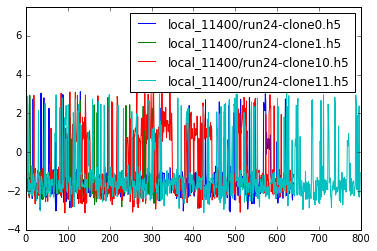

In [15]:
# checking files 4 at a time, for readability
for f in files[0:4]:
    plt.plot(dfg_angle_trajectories[f], label=f)
plt.ylim(-4, 7.5)
plt.legend();

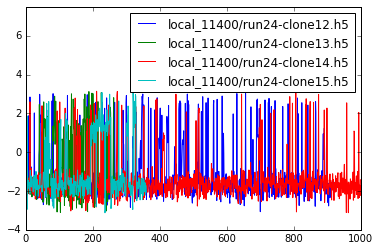

In [16]:
for f in files[4:8]:
    plt.plot(dfg_angle_trajectories[f], label=f)
plt.ylim(-4, 7.5)
plt.legend();

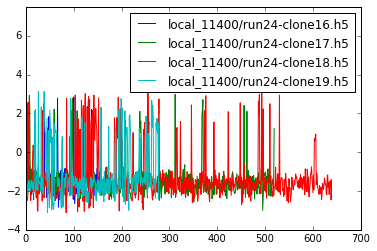

In [17]:
for f in files[8:12]:
    plt.plot(dfg_angle_trajectories[f], label=f)
plt.ylim(-4, 7.5)
plt.legend();

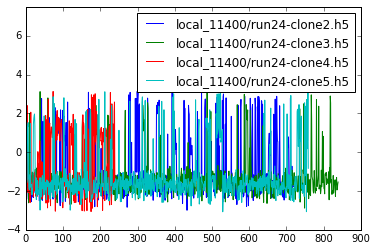

In [18]:
for f in files[12:16]:
    plt.plot(dfg_angle_trajectories[f], label=f)
plt.ylim(-4, 7.5)
plt.legend();

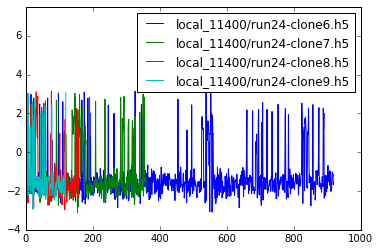

In [19]:
for f in files[16:20]:
    plt.plot(dfg_angle_trajectories[f], label=f)
plt.ylim(-4, 7.5)
plt.legend();

After looking at all of those, I pick one clone that looks interesting.

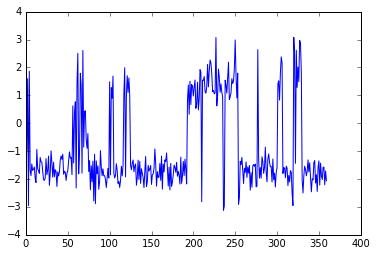

In [20]:
favorite = 'local_11400/run24-clone15.h5'
plt.plot(dfg_angle_trajectories[favorite]);

In [21]:
traj = ops_load_trajectory(favorite)

A few quick calculations I can do to see how often we're in each state (versus not in any state). We want to have a decent bit of flux, meaning that we don't want too many frames to actually be *inside* the state definition.

In [22]:
n_frames_in = sum([less.DFG_in(s) for s in traj])
n_frames_out = sum([less.DFG_out(s) for s in traj])
n_frames = len(traj)
print "DFG in:  " + str(n_frames_in) + "/" + str(n_frames)
print "DFG out: " + str(n_frames_out) + "/" + str(n_frames)

DFG in:  75/360
DFG out: 188/360


In [23]:
tps_transition = paths.TPSTransition(less.DFG_out, less.DFG_in)

In [24]:
# analyzer for clone 15
analyzer_c15 = paths.SingleTrajectoryAnalysis(tps_transition, dt=None).analyze(traj)

In [25]:
%%time
all_trajs = [ops_load_trajectory(filename) for filename in files]

CPU times: user 6.08 s, sys: 426 ms, total: 6.51 s
Wall time: 6.51 s


In [26]:
%%time
# analyzer for all clones of run 24
all_analyzer = paths.SingleTrajectoryAnalysis(tps_transition, dt=None).analyze(all_trajs)

CPU times: user 2min, sys: 1.32 s, total: 2min 1s
Wall time: 2min 1s


### Characteristic times measured by `SingleTrajectoryAnalysis`

`SingleTrajectoryAnalysis` gives an easy way to calculate several timescales of interest in rare events. I'm going to call these the "continuous time" in the state ($t_c$), the "lifetime" of the state ($\tau$), and the "duration" of the transition ($t_d$). Each of these is actually a distribution, with a well-defined average.

We will also consider the flux out of the state ($\Phi_\text{state}$).

Keep in mind that there are a few ways of thinking about being "in a state." On one hand, we have our state definitions, which are set in the `Unimore` class as specific allowed ranges of the DFG angle. But by that definition of the state, when we "leave" the state, we almost always immediately return to the state.

The way of thinking is a bit more immediately intuitive, and basically removes the no-man's land. Every frame is either in one state or in the other state. But while frames in a given trajectory can be assigned to a state in this way, you can't just look at a single snapshot (absent the context of the trajectory) and assign it. What if that snapshot comes from somewhere near the 50% isocommittor surface?

Below, you'll see ways to identify segments based on both of those. The "continuous time" gives the first version, whereas "lifetimes" gives the second. We also look at the duration of the transition, which is the amount of time during a transition between two states that the system is in neither of the defined states. These are the segments we sample with TPS.

#### Why do we care?

All of this boils down to the questions: How large should we make our states? What range of values should be defined as "in" each state? Too small of a target, and you jump over it between frames. But the larger the target, the less of an advantage you get from TIS (the area outside the state gets exponential speed-ups in TIS).

In general, you probably want something on the order of some small number of $k_\text{B} T$ included within your state (1 or 2, maybe 3 $k_\text{B} T$ seems reasonable). That usually gives you a large enough target to hit, without having internal barriers that are hard to sample.


#### Dealing with decimated data

The FAH data tends to have very large time steps between successive frames. This can affect some of the numbers we're interested in.

For example, the continuous time may not be accurate. The flux (which basically depends on the ratio of frames outside the state to inside the state) is still accurate, but if each flux event (each excursion out of the state) only consists of 1 or 2 frames, then it is hard to be sure that the timescales aren't hidden by the large time step. (There's a bit of a British Coastline problem here.)

The transition duration can also suffer from problems if the actual transition duration is shorter than the time between frames. In this case, the duration registers as 0. It is still possible that launching trajectories from either endpoint of a zero-duration transition will give a starting trajectory, but it is better to start from a trajectory that has some frames in the no-man's land.

#### Continuous time

The continuous time is perhaps the easiest to understand. It is the time spent *in* the state. As such, it very much depends on how big you make your state boundaries. If the continuous time is very large, then our state is probably too large (there's a very low flux to leave it). If the continuous time is too small, then our state may either be too small of a target or it might not be large enough to decorrelate within it.

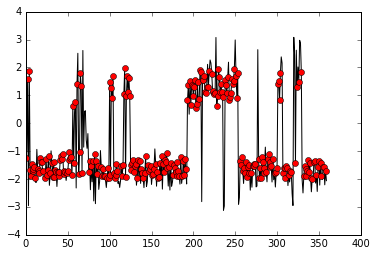

In [55]:
in_indices = traj.subtrajectory_indices(
    analyzer_c15.continuous_segments[less.DFG_in]
)
out_indices = traj.subtrajectory_indices(
    analyzer_c15.continuous_segments[less.DFG_out]
)
plt.plot(less.dfg(traj), 'k')
for (x_vals, seg) in zip(in_indices, analyzer_c15.continuous_segments[less.DFG_in]):
    if x_vals != []:
        plt.plot(x_vals, less.dfg(seg), 'ro')
for (x_vals, seg) in zip(out_indices, analyzer_c15.continuous_segments[less.DFG_out]):
    if x_vals != []:
        plt.plot(x_vals, less.dfg(seg), 'ro')

#### Lifetime

The lifetime is a very important quantity. It is defined by the time from when the trajectory first enters the state until the trajectory enters another state. The rate of a process is given by $k = 1/<\tau>$. As such, observing the lifetime from a lot of long trajectories can give us an estimate of the rate (and methods such as TIS can then give much better precision.)

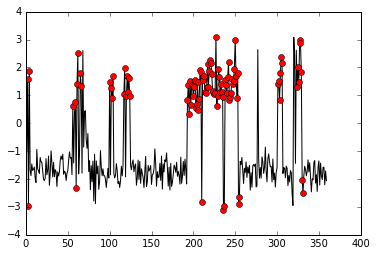

In [56]:
in_out_lifetime_indices = traj.subtrajectory_indices(
    analyzer_c15.lifetime_segments[less.DFG_in]
)
plt.plot(less.dfg(traj), 'k')
for (x_vals, seg) in zip(in_out_lifetime_indices, analyzer_c15.lifetime_segments[less.DFG_in]):
    if x_vals != []:
        plt.plot(x_vals, less.dfg(seg), 'ro')

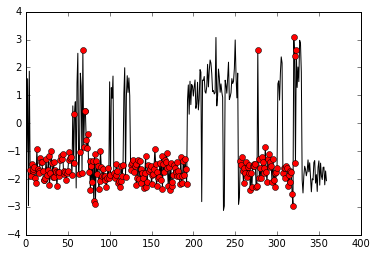

In [57]:
out_in_lifetime_indices = traj.subtrajectory_indices(
    analyzer_c15.lifetime_segments[less.DFG_out]
)
plt.plot(less.dfg(traj), 'k')
for (x_vals, seg) in zip(out_in_lifetime_indices, analyzer_c15.lifetime_segments[less.DFG_out]):
    if x_vals != []:
        plt.plot(x_vals, less.dfg(seg), 'ro')

#### Duration of the transition



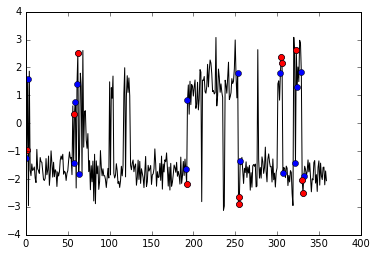

In [49]:
transition_in_out_indices = traj.subtrajectory_indices(
    analyzer_c15.transition_segments[(less.DFG_in, less.DFG_out)]
)
transition_out_in_indices = traj.subtrajectory_indices(
    analyzer_c15.transition_segments[(less.DFG_out, less.DFG_in)]
)
tps_in_out = paths.SequentialEnsemble([
    paths.AllInXEnsemble(less.DFG_in) & paths.LengthEnsemble(1),
    paths.AllOutXEnsemble(less.DFG_in | less.DFG_out),
    paths.AllInXEnsemble(less.DFG_out) & paths.LengthEnsemble(1),
])
tps_out_in = paths.SequentialEnsemble([
    paths.AllInXEnsemble(less.DFG_out) & paths.LengthEnsemble(1),
    paths.AllOutXEnsemble(less.DFG_in | less.DFG_out),
    paths.AllInXEnsemble(less.DFG_in) & paths.LengthEnsemble(1),
])
tps_in_out_indices = traj.subtrajectory_indices(tps_in_out.split(traj))
tps_out_in_indices = traj.subtrajectory_indices(tps_out_in.split(traj))
plt.plot(less.dfg(traj), 'k')
for (x_vals, seg) in zip(tps_in_out_indices, tps_in_out.split(traj)):
    plt.plot(x_vals, less.dfg(seg), 'bo')
for (x_vals, seg) in zip(tps_out_in_indices, tps_out_in.split(traj)):
    plt.plot(x_vals, less.dfg(seg), 'bo')
for (x_vals, seg) in zip(transition_in_out_indices, analyzer_c15.transition_segments[(less.DFG_in, less.DFG_out)]):
    plt.plot(x_vals, less.dfg(seg), 'ro', linewidth=2.0)
for (x_vals, seg) in zip(transition_out_in_indices, analyzer_c15.transition_segments[(less.DFG_out, less.DFG_in)]):
    plt.plot(x_vals, less.dfg(seg), 'ro', linewidth=2.0)

#### Flux

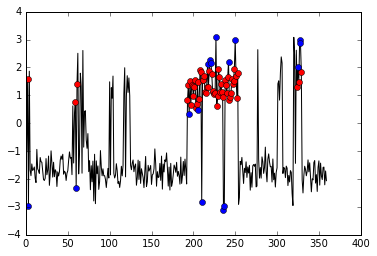

In [53]:
flux_in_dfgIN = analyzer_c15.flux_segments[less.DFG_in]['in']
flux_out_dfgIN = analyzer_c15.flux_segments[less.DFG_in]['out']

plt.plot(less.dfg(traj), 'k')
for (x_vals, seg) in zip(traj.subtrajectory_indices(flux_in_dfgIN), flux_in_dfgIN):
    plt.plot(x_vals, less.dfg(seg), 'ro')
for (x_vals, seg) in zip(traj.subtrajectory_indices(flux_out_dfgIN), flux_out_dfgIN):
    plt.plot(x_vals, less.dfg(seg), 'bo')

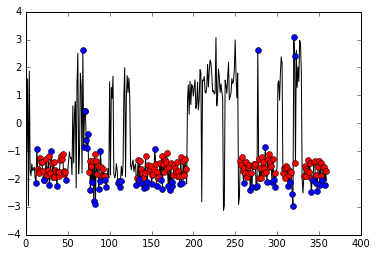

In [58]:
flux_in_dfgOUT = analyzer_c15.flux_segments[less.DFG_out]['in']
flux_out_dfgOUT = analyzer_c15.flux_segments[less.DFG_out]['out']
plt.plot(less.dfg(traj), 'k')
for (x_vals, seg) in zip(traj.subtrajectory_indices(flux_in_dfgOUT), flux_in_dfgOUT):
    plt.plot(x_vals, less.dfg(seg), 'ro')
for (x_vals, seg) in zip(traj.subtrajectory_indices(flux_out_dfgOUT), flux_out_dfgOUT):
    plt.plot(x_vals, less.dfg(seg), 'bo')

In [59]:
def out_in_ratio(flux_segment_dict):
    mean_out = np.array([len(s) for s in flux_segment_dict['out']]).mean()
    mean_in = np.array([len(s) for s in flux_segment_dict['in']]).mean()
    return mean_out / mean_in

In [60]:
print "Flux out:in for DFG-out", out_in_ratio(analyzer_c15.flux_segments[less.DFG_out])
print "Flux out:in for DFG-in", out_in_ratio(analyzer_c15.flux_segments[less.DFG_in])

Flux out:in for DFG-out 0.459608843537
Flux out:in for DFG-in 0.351648351648


### Histograms from the analyzers

Now let's take a look at what this analysis can tell us.

Note that, since I don't know the correct value for `dt`, I'm currently using results based on the number of frames. If `dt` is not `None`, you can use versions that will gives results in units of time, instead of frames. The functions map as:

* `.continuous_frames` -> `.continuous_times`
* `.lifetime_frames` -> `.lifetimes`
* `.transition_duration_frames` -> `.transition_duration`

Everything else stays the same.

First, let's define a little function that returns an appropriate binning procedure for these histograms.

In [35]:
def set_bins(list_of_inputs, binwidth_scale=1.0):
    maximum = max([max(ll) for ll in list_of_inputs])
    minimum = min([min(ll) for ll in list_of_inputs])

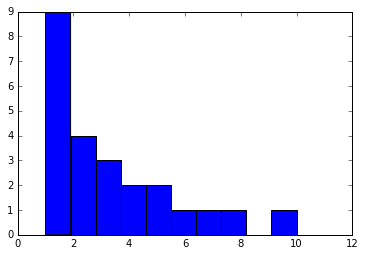

In [36]:
plt.hist(analyzer_c15.continuous_frames[less.DFG_in]);

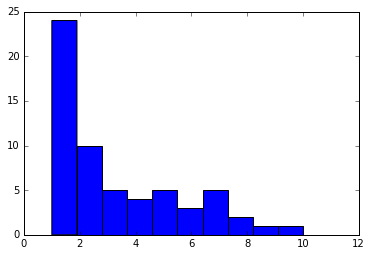

In [37]:
plt.hist(analyzer_c15.continuous_frames[less.DFG_out]);

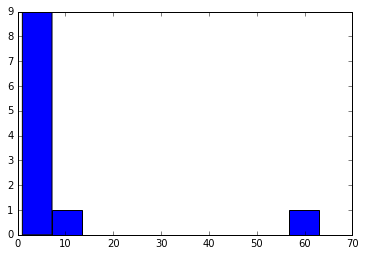

In [38]:
plt.hist(analyzer_c15.lifetime_frames[less.DFG_in]);

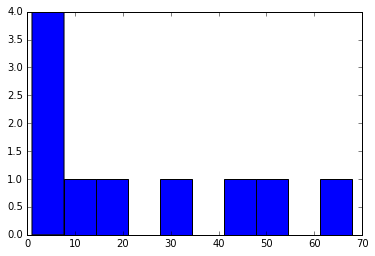

In [39]:
plt.hist(analyzer_c15.lifetime_frames[less.DFG_out]);

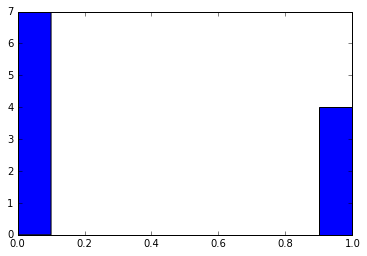

In [40]:
plt.hist(analyzer_c15.transition_duration_frames[(less.DFG_out, less.DFG_in)]);

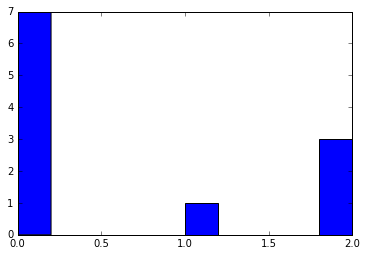

In [41]:
plt.hist(analyzer_c15.transition_duration_frames[(less.DFG_in, less.DFG_out)]);

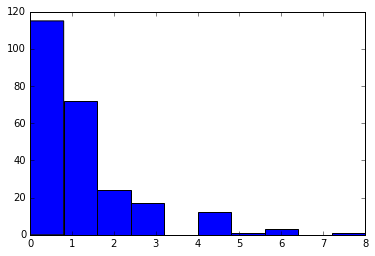

In [42]:
plt.hist(all_analyzer.transition_duration_frames[(less.DFG_in, less.DFG_out)]);

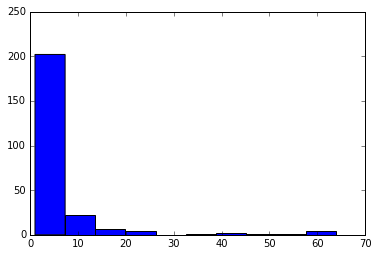

In [43]:
plt.hist(all_analyzer.lifetime_frames[less.DFG_in]);

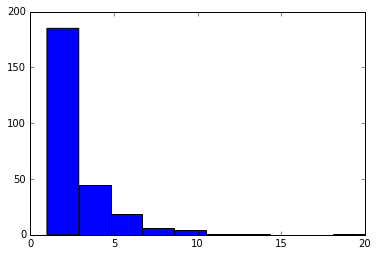

In [65]:
plt.hist([len(s) for s in all_analyzer.flux_segments[less.DFG_in]['in']]);

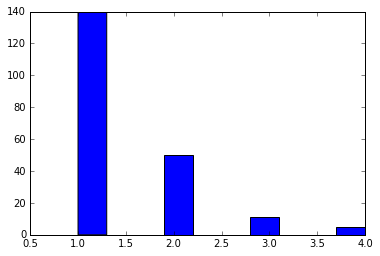

In [66]:
plt.hist([len(s) for s in all_analyzer.flux_segments[less.DFG_in]['out']]);